In [1]:
import numpy as np
import pandas as pd

# please make sure the file preprocessing.py is in place
import preprocessing as pp

# also, vectorization.py
import vectorization as vz

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data = pd.read_csv('modified_dataset.csv')
data_copy = data
data_copy.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,13,eebbqej
1,"Now if he does off himself, everyone will thin...",13,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,7,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


## Data Preprocessing

Using **unigrams**, **lemmatization**, and removal of **additional** stopwords.

In [3]:
# remove punctuations
data['pre'] = data['text'].apply(pp.remove_punctuations)

# unigram (or simply tokenization)
data['pre'] = data['pre'].apply(lambda x: pp.n_grams(x, n=1))

# lemmatize
data['pre'] = data['pre'].apply(pp.lem)

# remove stopwords
# define extra stopwords
stops = ['name', 'religion']
data['pre'] = data['pre'].apply(lambda x: pp.remove_stopwords(x, sw=stops))

## Text vectorization

Using **Word2Vec**

In [4]:
X = vz.Word2Vec(data['pre'])

## Split to train/test datasets

Using ``train_test_split`` from the ``sklearn.model_selection`` library. Setting ``random_state`` parameter to **14**, and ``test_size`` to **0.25**.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['labels'].values, random_state=14, test_size=0.25)

## Train the model 

### Variation #1

Using **XGBoost**

Parameters: 
- eta = 0.1
- max_depth = 8

In [6]:
from xgboost import XGBClassifier
print("Variation #1 - XGBoost")
model1 = XGBClassifier(tree_method="gpu_hist", eta=0.1, max_depth=8)
model1.fit(X_train, y_train)

Variation #1 - XGBoost


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
y_pred1 = model1.predict(X_test)



### Variation #2

Using **Bidirectional LSTM**
- Optimizer = Adam
- LSTM layer with 64 neurons with dropout of 0.7 

In [8]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
import time
start = time.time()

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

print("Variation #2 - Bidirectional LSTM")

model2 = Sequential()

model2.add(Bidirectional(LSTM(256)))
model2.add(Dropout(0.7))
model2.add(Dense(14, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.25)

Variation #2 - Bidirectional LSTM
Epoch 1/20
954/954 [==============================] - 113s 67ms/step - loss: 1.9847 - accuracy: 0.3899 - val_loss: 1.8111 - val_accuracy: 0.4421
Epoch 2/20
954/954 [==============================] - 56s 59ms/step - loss: 1.7994 - accuracy: 0.4384 - val_loss: 1.7501 - val_accuracy: 0.4507
Epoch 3/20
954/954 [==============================] - 59s 62ms/step - loss: 1.7508 - accuracy: 0.4530 - val_loss: 1.7208 - val_accuracy: 0.4617
Epoch 4/20
954/954 [==============================] - 77s 81ms/step - loss: 1.7180 - accuracy: 0.4637 - val_loss: 1.7036 - val_accuracy: 0.4665
Epoch 5/20
954/954 [==============================] - 52s 54ms/step - loss: 1.6937 - accuracy: 0.4644 - val_loss: 1.6890 - val_accuracy: 0.4699
Epoch 6/20
954/954 [==============================] - 44s 46ms/step - loss: 1.6764 - accuracy: 0.4713 - val_loss: 1.6771 - val_accuracy: 0.4747
Epoch 7/20
954/954 [==============================] - 47s 49ms/step - loss: 1.6597 - accuracy: 0.4779

In [11]:
y_pred2 = model2.predict(X_test)

y_pred2 = np.array([np.where(x == np.max(x))[0] for x in y_pred2])


424/424 [==============================] - 36s 72ms/step


In [12]:
print("Time elapsed: " + str(time.time()-start) + " seconds")

Time elapsed: 2500.053017139435 seconds


**Variation #3**

Using ``GaussianNB`` from **Naive Bayes**

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [14]:
from sklearn.naive_bayes import GaussianNB
print("Variation #3 - Naive Bayes")
model3 = GaussianNB()
model3.fit(X_train, y_train)

Variation #3 - Naive Bayes


GaussianNB()

In [15]:
y_pred3 = model3.predict(X_test)


**Variation #4**

Using **Support Vector Machines**

In [16]:
import time
start = time.time()

In [17]:
from sklearn.svm import SVC
print("Variation #4 - Support Vector Machines")
model4 = SVC()
model4.fit(X_train, y_train)

Variation #4 - Support Vector Machines


SVC()

In [18]:
y_pred4 = model4.predict(X_test)
print("Time elapsed: " + str(time.time()-start) + " seconds")

Time elapsed: 1647.5378189086914 seconds


## Model Evaluation

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
# Variation 1
print("Variation #1 - XGBoost")
print(classification_report(y_test, y_pred1))
print("-"*100)
print("Confusion Matrix",confusion_matrix(y_test, y_pred1), sep="\n\n")

Variation #1 - XGBoost
              precision    recall  f1-score   support

           0       0.58      0.52      0.55      1302
           1       0.56      0.40      0.47       893
           2       0.58      0.18      0.28       460
           3       0.31      0.11      0.17       874
           4       0.25      0.05      0.08       760
           5       0.47      0.06      0.10       957
           6       0.41      0.14      0.21       667
           7       0.45      0.05      0.09       733
           8       0.79      0.71      0.75       712
           9       0.52      0.23      0.32       660
          10       0.58      0.36      0.44       812
          11       0.50      0.20      0.29       337
          12       0.51      0.12      0.19       327
          13       0.40      0.90      0.56      4072

    accuracy                           0.45     13566
   macro avg       0.49      0.29      0.32     13566
weighted avg       0.47      0.45      0.39     13566

--

In [20]:
# Variation 2
print("Variation #2 - Bidirectional LSTM")
print(classification_report(y_test, y_pred2))
print("-"*100)
print("Confusion Matrix",confusion_matrix(y_test, y_pred2), sep="\n\n")

Variation #2 - Bidirectional LSTM
              precision    recall  f1-score   support

           0       0.55      0.64      0.59      1302
           1       0.53      0.57      0.55       893
           2       0.42      0.32      0.36       460
           3       0.35      0.18      0.24       874
           4       0.30      0.09      0.14       760
           5       0.47      0.08      0.14       957
           6       0.47      0.19      0.27       667
           7       0.50      0.12      0.19       733
           8       0.77      0.81      0.79       712
           9       0.46      0.34      0.39       660
          10       0.54      0.48      0.51       812
          11       0.48      0.34      0.39       337
          12       0.48      0.16      0.24       327
          13       0.46      0.81      0.58      4072

    accuracy                           0.49     13566
   macro avg       0.48      0.36      0.38     13566
weighted avg       0.48      0.49      0.44   

In [21]:
# Variation 3
print("Variation #3 - Naive Bayes")
print(classification_report(y_test, y_pred3))
print("-"*100)
print("Confusion Matrix",confusion_matrix(y_test, y_pred3), sep="\n\n")

Variation #3 - Naive Bayes
              precision    recall  f1-score   support

           0       0.63      0.30      0.41      1302
           1       0.26      0.43      0.32       893
           2       0.15      0.32      0.21       460
           3       0.23      0.17      0.19       874
           4       0.12      0.18      0.15       760
           5       0.19      0.04      0.06       957
           6       0.26      0.13      0.18       667
           7       0.25      0.05      0.08       733
           8       0.80      0.48      0.60       712
           9       0.40      0.16      0.23       660
          10       0.55      0.32      0.40       812
          11       0.06      0.70      0.11       337
          12       0.12      0.29      0.17       327
          13       0.53      0.26      0.35      4072

    accuracy                           0.26     13566
   macro avg       0.32      0.27      0.25     13566
weighted avg       0.40      0.26      0.28     13566

In [22]:
# Variation 4
print("Variation #4 - Support Vector Machines")
print(classification_report(y_test, y_pred4))
print("-"*100)
print("Confusion Matrix",confusion_matrix(y_test, y_pred4), sep="\n\n")

Variation #4 - Support Vector Machines
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1302
           1       0.62      0.53      0.57       893
           2       0.55      0.25      0.34       460
           3       0.39      0.14      0.21       874
           4       0.42      0.03      0.06       760
           5       0.63      0.03      0.06       957
           6       0.48      0.19      0.27       667
           7       0.72      0.05      0.08       733
           8       0.80      0.81      0.81       712
           9       0.53      0.31      0.39       660
          10       0.60      0.45      0.52       812
          11       0.53      0.32      0.40       337
          12       0.55      0.17      0.25       327
          13       0.43      0.90      0.58      4072

    accuracy                           0.49     13566
   macro avg       0.56      0.34      0.37     13566
weighted avg       0.53      0.49      0.

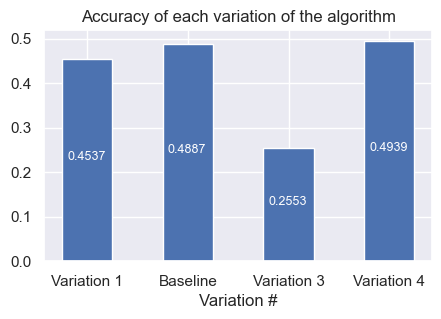

In [23]:
import seaborn
seaborn.set()
results=(y_pred1, y_pred2, y_pred3, y_pred4)
names = [('Variation '+str(i+1)) for i in range(len(results))]
names[1] = "Baseline"

from sklearn.metrics import accuracy_score

acc = [accuracy_score(y_test, y) for y in results]

import matplotlib.pyplot as plt
# plot the results

plt.figure(figsize=(5,3))
plt.bar(names, acc,0.5, label="Accuracy")
for i in range(4):
    plt.text(i-0.2, acc[i]/2, round(acc[i],4), fontdict={'size':9,'color':'white' })
# plt.plot(names,acc, marker='.', color='red')
plt.xlabel("Variation #")
plt.title("Accuracy of each variation of the algorithm")
plt.show()

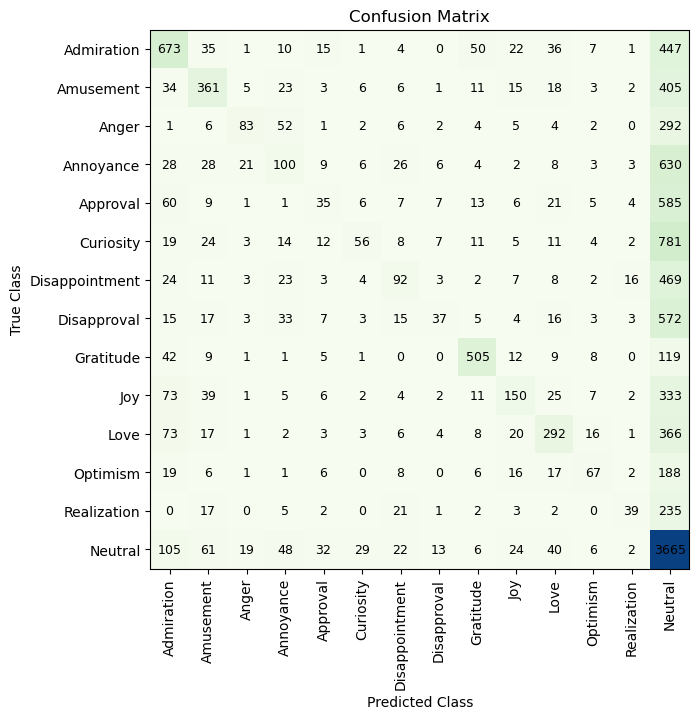

In [30]:
seaborn.reset_orig()

labs = ["Admiration", "Amusement", "Anger", "Annoyance", "Approval", "Curiosity", "Disappointment", "Disapproval", "Gratitude", "Joy", "Love", "Optimism", "Realization", "Neutral"]
cm = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='GnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(i, j, cm[j,i],fontsize=9, ha='center', va='center')
plt.xticks(ticks=range(14), labels=labs, rotation=90)
plt.yticks(ticks=range(14), labels=labs)
plt.ylabel('True Class')
plt.show()

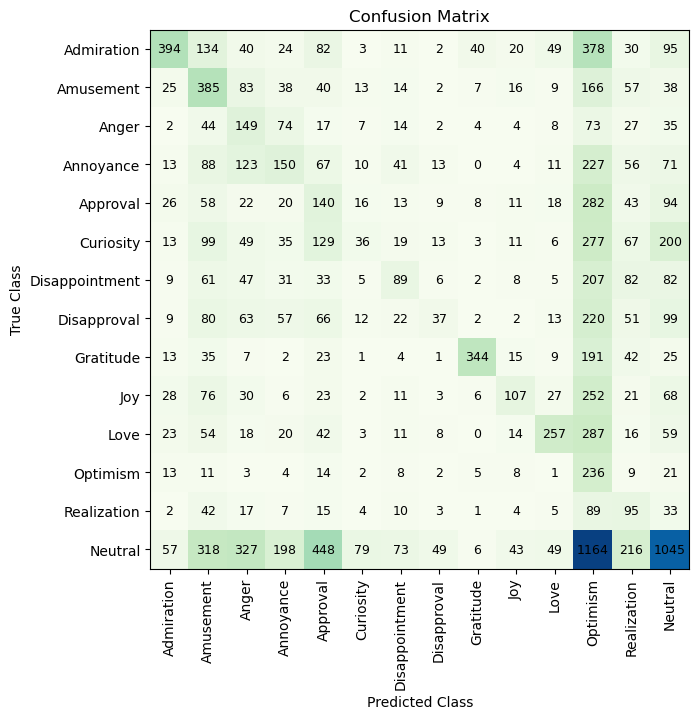

In [31]:
labs = ["Admiration", "Amusement", "Anger", "Annoyance", "Approval", "Curiosity", "Disappointment", "Disapproval", "Gratitude", "Joy", "Love", "Optimism", "Realization", "Neutral"]
cm = confusion_matrix(y_test, y_pred3)

plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='GnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(i, j, cm[j,i],fontsize=9, ha='center', va='center')
plt.xticks(ticks=range(14), labels=labs, rotation=90)
plt.yticks(ticks=range(14), labels=labs)
plt.ylabel('True Class')
plt.show()

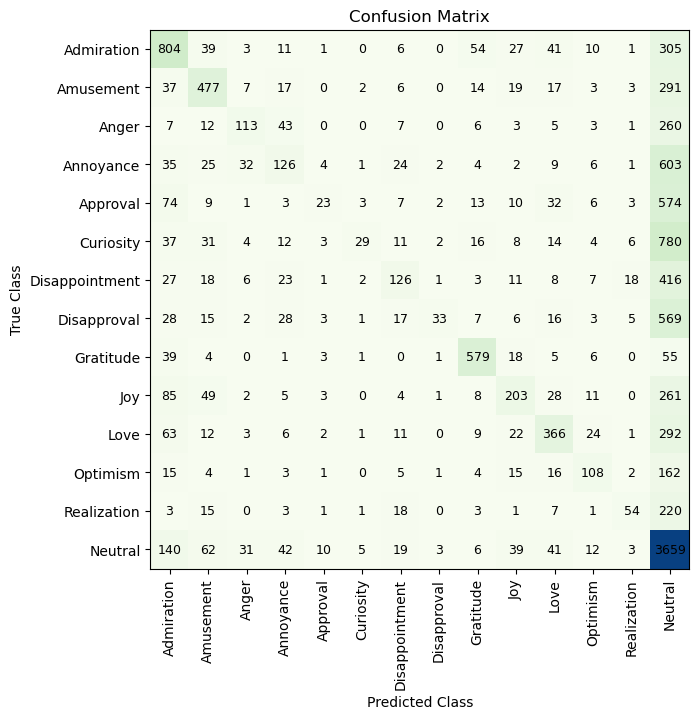

In [32]:
labs = ["Admiration", "Amusement", "Anger", "Annoyance", "Approval", "Curiosity", "Disappointment", "Disapproval", "Gratitude", "Joy", "Love", "Optimism", "Realization", "Neutral"]
cm = confusion_matrix(y_test, y_pred4)

plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='GnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(i, j, cm[j,i],fontsize=9, ha='center', va='center')
plt.xticks(ticks=range(14), labels=labs, rotation=90)
plt.yticks(ticks=range(14), labels=labs)
plt.ylabel('True Class')
plt.show()